# The Representation Jensen-Rényi Divergence
## Imbalanced data Representation

In this notebook we perform experiments to subsample imbalanced datasets by using the **Representation Jensen-Rényi Divergence (JRD)**. In particular, in imbalanced data classification, there is one class that has a higher number of samples than the other. Here, we are interested in subsampling the majority class by finding a set of fewer samples that minimizes its divergence with the majority class.

In [14]:
%matplotlib inline
from IPython import display
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_moons


import repitl.divergences as div
import repitl.kernel_utils as ku
import repitl.matrix_itl_approx as approx
import repitl.matrix_itl as itl

## Representation subsampling DEMO
Here, we show a DEMO on a toy dataset to visualize how the subsampling works. Suppose the blue points from the moons dataset are the majority class containing $N$ samples, and you want to subsample $m$ samples from it. To achieve this, we draw $m$ samples uniformly distributed in the range where the data is distributed, and let those points to minimize its divergence with respect to the original set of points.

In [15]:
def JRD_sampling(X,n_samples,sigma= 1,alpha=1.01,lr = 0.1, n_iter = 120, weighted = False, n_rff = None, plot = False):
    '''
    Function to select a set of relevant samples by minimizing JRD
    Args: 
        X: Dataset to subsample from
        n_samples: Number of samples to select from X
        sigma: Kernel bandwidth
        alpha: Order of the entropy
        lr: Learning rate
        n_iter : Number of iterations
        weighted: variable to control if using weighted version of the JRD
        n_rff: Number of Random Fourier Features to approximate Gaussian Kernel,
               If it is None, regular JRD is computed without any approximation
        plot: variable to specify if plotting or not.
    '''
    n = X.shape[0]
    d = X.shape[1]
    # Samples uniformly sampled in the range -2 to 2. This range can be modified according to the 
    # range where the data is distributed. (This range work well for standard-normalized data)
    Y_ = np.random.uniform(-2.0, 2.0, (n_samples, d))
    # Convert data to torch and create labels
    X = torch.from_numpy(X)
    Y = torch.tensor(Y_,requires_grad = True,dtype=X.dtype)

    optimizer = torch.optim.Adam([Y, ], lr=lr)
    
    # Plot configuration
    if plot:
        fig, ax = plt.subplots(1,1,figsize=(4,4))
    
    for i in range(n_iter):
        optimizer.zero_grad()
        djr = div.divergenceJR(X,Y,sigma,alpha, weighted = weighted, n_rff = n_rff)   
        djr.backward()
        optimizer.step()
        if plot:            
            ax.cla()
            ax.plot(X[:,0],X[:,1] ,'.')
            ax.plot(Y[:,0].detach().numpy(),Y[:,1].detach().numpy(),'.',c='#FF7F50',markersize=20)
            ax.set_aspect('equal')
            ax.set_xlim((-2., 2.))
            ax.set_ylim((-2., 2.))
            ax.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            
    return Y.detach().numpy() 

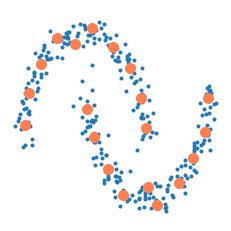

In [16]:
N = 300 # Samples in the majority class
m = 20  # Number of samples to select
X, _ = make_moons(noise=0.08, random_state=1, n_samples = N)
scaler = StandardScaler()    # Data normalization
X = scaler.fit_transform(X)
X_subsampled = JRD_sampling(X,n_samples = m,sigma = 0.5,alpha=1.01,lr = 0.1, n_iter = 300, weighted = True, plot = True)

## Imbalanced data classification experiments

In the next section you will find the experiments conducted in the paper "The Representation Jensen-Renyí divergence" for imbalanced data classification. 

We assessed the JRD subsampling on 44 imbalanced, two-class datasets from the “Knowledge Extraction based on
Evolutionary Learning” (KEEL) repository. Next, we provide functions to load the datasets.

In [17]:
# Load datasets
def load_dataset(dataset,fold):
    """
    Function to load imbalanced datasets from KEEL repository
    Args: 
        dataset: Dataset name
        fold: fold number
    Returns:
        Xtrain,Ytrain,Xtest,Ytest: Train and testing sets
    """
    ftrain= './Imbalanced_data/' + dataset + '-5-' + str(fold) + 'tra.dat'
    ftest = './Imbalanced_data/' + dataset + '-5-' + str(fold) + 'tst.dat'
    df     = pd.read_table(ftrain,sep = ',',delimiter = ',', header = None, comment='@', skiprows = 0,engine='python')
    dftest = pd.read_table(ftest ,sep = ',',delimiter = ',', header = None, comment='@', skiprows = 0,engine='python')
    Xtrain = df._get_numeric_data()
    Xtrain = Xtrain.to_numpy()
    Ytrain = df.iloc[:,-1].values
    Ytrain[Ytrain == ' positive'] = 1
    Ytrain[Ytrain == ' negative'] = 0
    Xtest = dftest._get_numeric_data()
    Xtest = Xtest.to_numpy()
    Ytest = dftest.iloc[:,-1:].values
    Ytest[Ytest == ' positive'] = 1
    Ytest[Ytest == ' negative'] = 0
    return Xtrain,Ytrain.astype(int),Xtest,Ytest.astype(int)

datasets = ['abalone9-18',
'abalone19',
'ecoli-0_vs_1',
'ecoli-0-1-3-7_vs_2-6',
'ecoli1',
'ecoli2',
'ecoli3',
'ecoli4',
'glass0',
'glass-0-1-2-3_vs_4-5-6',
'glass-0-1-6_vs_2',
'glass-0-1-6_vs_5',
'glass1',
'glass2',
'glass4',
'glass5',
'glass6',
'haberman',
'iris0',
'new-thyroid1',
'newthyroid2',
'page-blocks0',
'page-blocks-1-3_vs_4',
'pima',
'segment0',
'shuttle-c0-vs-c4',
'shuttle-c2-vs-c4',
'vehicle0',
'vehicle1',
'vehicle2',
'vehicle3',
'vowel0',
'wisconsin',
'yeast-0-5-6-7-9_vs_4',
'yeast1',
'yeast-1_vs_7',
'yeast-1-2-8-9_vs_7',
'yeast-1-4-5-8_vs_7',
'yeast-2_vs_4',
'yeast-2_vs_8',
'yeast3',
'yeast4',
'yeast5',
'yeast6']

For any dataset, we subsample the majority class according to the number of samples in the minority class to balance the class distribution and avoid biased classification results. Then we train a Support Vector Machine (SVM) to assess the performance of our method. We perform a nested cross-validation to find the best kernel bandwidth ($\sigma$) for the Gaussian Kernel involved in the computation of JRD.

In [18]:
def train_imbalanced(dataset, n_rff = None):
    """
    This function performs the JRD-subsampling and classification
    for an imbalanced dataset in the KEEL repository. It returns the
    Area Under the ROC curve (AUC) at every fold of the dataset. 
    
    Optional arg:
        n_rff: Number of Random Fourier Features to approximate Gaussian Kernel
    """
    print(f'Processing {dataset} dataset ')

    AUC = np.zeros(5)
    alpha = 1.01
    n_sigmas = 10   

    for fold in range(1,6):
        print(f'Processing Fold {fold}')
        Xtrain,Ytrain,Xtest,Ytest = load_dataset(dataset,fold)
        # Standard normalization
        scaler = StandardScaler()
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest  = scaler.transform(Xtest)
        #Find the majority and minority classes
        maj_label = np.bincount(Ytrain).argmax()
        min_label = np.bincount(Ytrain).argmin()
        # Separate the data into majority and minority class 
        Xmaj = Xtrain[Ytrain == maj_label,:]
        Xmin = Xtrain[Ytrain == min_label,:]
        #Sigma tuning for subsampling
        # nested cross-val
        Xtrain_, Xtest_, Ytrain_, Ytest_ = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=42)
        Xmaj_cv = Xtrain_[Ytrain_ == maj_label,:]
        Xmin_cv = Xtrain_[Ytrain_ == min_label,:]

        sigma0 = np.nanmedian(pairwise_distances(Xmaj_cv))
        sigmas = np.linspace(0.01*sigma0,3*sigma0,n_sigmas)
        AUC_cv = np.zeros(sigmas.size)
        for i,sigma in enumerate(sigmas):
            Xmaj_cv_ = JRD_sampling(Xmaj_cv,n_samples= Xmin_cv.shape[0],sigma = sigma,alpha=alpha,lr = 0.1, weighted = True, n_rff = n_rff)
            Xtrain_cv = np.concatenate((Xmaj_cv_, Xmin_cv), axis=0)
            Ytrain_cv = np.concatenate((maj_label*np.ones(Xmaj_cv_.shape[0]),min_label*np.ones(Xmin_cv.shape[0])),axis=0)
            C_range = np.logspace(0,3,7)
            s0 = np.nanmedian(pairwise_distances(Xmaj_cv_))
            gamma_range = 1/(2*(np.linspace(0.01*s0,3*s0,7))**2)
            param_grid = dict(gamma=gamma_range,C=C_range)
            cv = StratifiedShuffleSplit(n_splits=4, test_size=0.25)
            grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
            grid.fit(Xtrain_cv, Ytrain_cv)
            best_params = grid.best_params_
            # Use those parameter to train a SVM        
            clf = SVC(kernel = 'rbf',C=best_params['C'], gamma=best_params['gamma'], probability = True)
            clf.fit(Xtrain_cv, Ytrain_cv)
            # Finally, compute the AUC score to assess the SVM performance
            try:
                AUC_cv[i] = roc_auc_score(Ytest_, clf.predict_proba(Xtest_)[:, 1])   
            except ValueError:
                pass
        #Choose the best sigma in the nested cross val
        sigma = sigmas[np.argmax(AUC_cv)]
        # Apply the subsampling with the best sigma
        Xmaj_ = JRD_sampling(Xmaj,n_samples = Xmin.shape[0],sigma =sigma,alpha=alpha,lr = 0.1, weighted = True, n_rff = n_rff)
        # Concatenate the subsampled set with the minority class
        Xtrain_ = np.concatenate((Xmaj_, Xmin), axis=0)
        Ytrain_ = np.concatenate((maj_label*np.ones(Xmaj_.shape[0]),min_label*np.ones(Xmin.shape[0])),axis=0)

        # Tune the parameters for the SVM        
        C_range = np.logspace(0,3,7)
        s0 = np.nanmedian(pairwise_distances(Xmaj_))
        gamma_range = 1/(2*(np.linspace(0.01*s0,3*s0,7))**2)

        param_grid = dict(gamma=gamma_range,C=C_range)
        cv = StratifiedShuffleSplit(n_splits=4, test_size=0.25)
        grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
        grid.fit(Xtrain_, Ytrain_)
        best_params = grid.best_params_
        # Use those parameter to train a SVM        
        clf = SVC(kernel = 'rbf',C=best_params['C'], gamma=best_params['gamma'], probability = True)
        clf.fit(Xtrain_, Ytrain_)

        # Finally, compute the AUC score to assess the SVM performance              
        AUC[(fold-1)] = roc_auc_score(Ytest, clf.predict_proba(Xtest)[:, 1])
    print(f'{dataset} was processed')
    return AUC

In [19]:
# You can run for any of the datasets in the list above.  
dataset = datasets[0]
AUC = train_imbalanced(dataset)
AUC

Processing abalone9-18 dataset 
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
abalone9-18 was processed


array([0.96215781, 0.96918086, 0.91485507, 0.92663043, 0.97810219])

In [11]:
# The same experiment using Random Fourier Features
dataset = datasets[0]
AUC = train_imbalanced(dataset,n_rff = 250)
AUC

Processing abalone9-18 dataset 
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
abalone9-18 was processed


array([0.95853462, 0.9351176 , 0.84782609, 0.92934783, 0.97729116])